In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from numpy.random import seed
from numpy.random import randint
import random
from math import sqrt
import string
import sys

### Read CSV
##### Input: filename

In [2]:
def read_file(name):
    df = pd.read_csv(name);
    # node names array
    namesArr = df.columns.values
    # nodes dictionary
    dict = {}
    for i in range(0, df.columns.size):
        dict[df.columns[i]] = i;
    return namesArr, dict, df.values

### Generate n nodes
##### Input: n (number of nodes), lim - space limit

In [3]:
def generate_nodes(n,lim): #For n <= 27
    mpositions = np.random.uniform(0,lim,(n,2))
    mdist = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            x1,y1 = mpositions[i,0],mpositions[i,1]
            x2,y2 = mpositions[j,0],mpositions[j,1]
            mdist[i,j] = mdist[j,i] = np.sqrt( (x1-x2)**2 + (y1-y2)**2 )
    nnames = [chr(x) for x in range(ord('A'),ord('Z')+1)]
    nnames = nnames[:n]
    ndict = {n:i for i,n in enumerate(nnames)}
    return nnames, mpositions, mdist, ndict
nnames, mpositions, mdist, ndict = generate_nodes(5,100)

### Objective Function
##### Input: nodes names array, nodes dictionary, distances matrix, individual array

In [4]:
def objective_function(namesArr,d, dMatrix, sol):
    if sol[0] != sol[len(sol)-1]:
        print("The first and last character must be the same ")
        return -1 #the fist and last character must be the same
    rep = sol[:len(sol)-1]
    if not len(set(rep)) == len(rep):
        print("the nodes are repeated")
        return -1 # the nodes are repeated
    if sorted(rep) != sorted(namesArr): 
        print("NOT all the nodes are included in the solution")
        return -1 # not all the nodes are included in the solution
    
    n = len(sol)-1
    w = 0;
    for i in range(0, n):
            w+=dMatrix[ord(sol[i])-65][ord(sol[i+1])-65]
    return w

# Genetic Algorithm

In [5]:
# variables
lim = 100
NNodes = 10 #population size
nnames, mpositions, mdist, ndict = generate_nodes(NNodes,lim)

In [6]:
def indices(lst, item):
    return [i for i, x in enumerate(lst) if x == item]

def combine(one, two):
    mid1 = ""
    mid2 = ""
    lenone = int(len(one)/2)
    for i in range(lenone):
        mid1 += one[i]
    for i in range(lenone):
        mid2 += two[i]
    mix = mid1+mid2
    # mix = mix[:-1] + mix[0] #first element = last element
    # look for repeated elements
    dupl = []
    uniqueDulp = []
    for i in range(len(list(mix))):
        if( len(indices(list(mix), mix[i])) > 1 ):
            #print(mix[i], indices(list(mix), mix[i]))
            dupl.append(indices(list(mix), mix[i]))
    # missing elements
    for i in range(len(dupl)):
        for j in range(1,len(dupl[i])):
            uniqueDulp.append( (dupl[i])[j] ) 
    uniqueDupl = np.unique(uniqueDulp)
    
    mix += mix[0] #first element = last element
    sortOne = sorted(one[:-1])
    sortMix = sorted(mix[:-1])
    miss = ""
    flag = False
    for i in range(len(sortOne)):
        for j in range(len(sortMix)):
            if(sortOne[i] == sortMix[j]):
                flag = True
                break
        if(flag == False):
            miss += sortOne[i]
        else: flag = False
    miss = list(miss)
    print(miss)
    mix = list(mix)    
    for i in range(len(uniqueDupl)):
        mix[uniqueDupl[i]] = miss[i]
    return ''.join(mix)   
    
def tournament_selection(parents, fitness, population):
    popsize = len(population)
    i1, i2 = np.random.choice(popsize,2)
    if fitness[i1] <= fitness[i2]:
        return population[i1,:]
    else:
        return population[i2,:]

In [7]:
def draw_elite(mpositions,nnames,ndict,elite):
    plt.figure()
    plt.scatter(mpositions[:,0],mpositions[:,1])
    for i in range(len(nnames)):
        plt.text(mpositions[i,0],mpositions[i,1],nnames[i])
    for i in range(len(elite)-1):
        n1, n2 = elite[i] , elite[i+1]
        i1, i2 = ndict[n1], ndict[n2]
        x1, y1 = mpositions[i1,0], mpositions[i1,1]
        x2, y2 = mpositions[i2,0], mpositions[i2,1]
        plt.plot( [x1,x2],[y1,y2] )
    plt.show()

In [8]:
def initial_population(m, names):
    population = np.zeros( (n,len(names)+1),'str')
    population[:,0] = names[0]
    population[:,-1] = names[0]
    for i in range(n):
        population[i,1:-1] = np.random.permutation( names[1:])
    return population

In [9]:
def fitness_population(population,mdist,ndict):
    N = len(population)
    fitness = np.zeros((N))
    for i in range(N):
        fitness[i] = fitness_individual(population[i,:],mdist,ndict)
    return fitness

def fitness_individual(ind,mdist,ndict):
    d = 0
    for i in range(len(ind)-1):
        n1 = ind[i]
        n2 = ind[i+1]
        d += mdist[ ndict[n1],ndict[n2] ]
    return d

In [10]:
def get_elite(population, fitness,elite=None,fitelite=None):
    idx = np.argsort(fitness)
    population = population[idx,:]
    fitness = fitness[idx]
    if elite is None:
        elite = np.copy(population[0,:])
        fitelite = fitness[0]
        return elite,fitelite
    if fitness[0] < fitelite:
        elite = np.copy(population[0,:])
        fitelite = fitness[0]
        return elite,fitelite
    return elite,fitelite

In [11]:
def crossover(parent1,parent2,nnames):
    pc = np.random.randint(1,len(parent1)-2)
    child = np.concatenate((parent1[:pc], parent2[pc:]))
    snodes = set(nnames)
    schild = set(child)
    repeated = set(parent1[1:pc]).intersection( set(parent2[pc:-1]) )
    missing = snodes.difference(schild)
    if len(repeated)>0:
        for i in range(len(child)):
            if child[i] in repeated:
                repeated.remove(child[i])
                child[i] = missing.pop()          
    return child  

In [12]:
def crossover_parents(population, pr, fitness, nnames): # pr = probability of reproduction
    gen = np.zeros_like(population)
    for i in range(len(population)):
        if(random.uniform(0, 1) < pr):
#             print("select two")
            first = tournament_selection(population, fitness, population)
            second = tournament_selection(population, fitness, population)
            child = crossover(first,second,nnames)#
            gen[i,:] = np.copy(child)
        else:
#             print("clone")
            parent = tournament_selection(population, fitness, population)
            gen[i,:] = np.copy(parent)
    return gen

In [13]:
def mutation_population(Pm,population):
    for i in range(len(population)):
        if np.random.rand() <= Pm:
            population[i,:] = mutation(population[i,:])
    return population

def mutation(individual):
    while True:
        pm1 = np.random.randint(1,len(individual)-1)
        pm2 = np.random.randint(1,len(individual)-1)
        if pm1 != pm2: break
    individual[pm1], individual[pm2] = individual[pm2], individual[pm1]
    return individual

First result: 
---------------------------------------------------------------------------------------
Best:  ['A' 'F' 'H' 'G' 'C' 'J' 'D' 'E' 'B' 'I' 'A'] ( 419.1633396122747 )


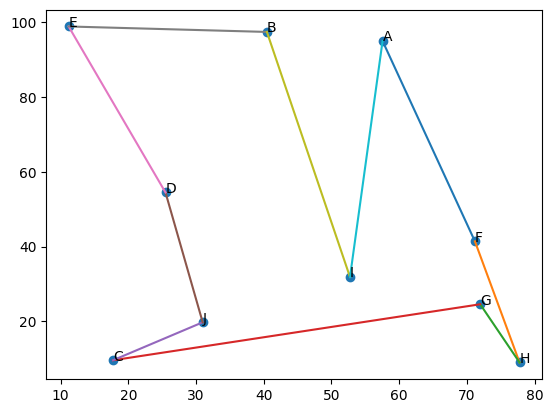

In [56]:
def genetic_algorithm(n, g, pr, pm):
    generate_nodes(n, 100) # returns nnames, mpositions, mdist, ndict
    #create the initial population
    population = initial_population(n, nnames)
    #Calculate the population fitness & get the elite
    fitness = fitness_population(population, mdist, ndict)
    elite, fitelite = get_elite(population, fitness)
    print("First result: ")
    #draw_elite(mpositions,nnames,ndict,elite)
    print("---------------------------------------------------------------------------------------")
    while g > 0: # While the number of generations is less than G or we haven’t found a good solution
        if g%400 == 0: 
            print("Best: ", elite, "(",fitelite,")")
            draw_elite(mpositions,nnames,ndict,elite)
        population = crossover_parents(population, pr, fitness, nnames)
        population = mutation_population(pm, population)
        
        fitness = fitness_population(population, mdist, ndict)
        elite, fitelite = get_elite(population, fitness, elite, fitelite)
        g-=1
        
n = 15 # n nodes
g = 400 # max number of generations
pr = 0.9 # reproduction's probability
pm = 0.1 # mutation probability
genetic_algorithm(n,g,pr,pm)